# Optimise B for SSPALS traces (looped data)

<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import sspals
import oskar

### Import

In [2]:
rid = '20160424_115511'
h5 = oskar.H5Data(rid)              # data
h5.load_log()
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Traces")    # output
h5.pprint()

20160108_190922
   Author:	 AD
   Description:  IR n = 18  Delay scan & TOF
		 UV 680 uJ with waveplate.
		 IR  2.5 mJ no waveplate
		 Target 2.0 kV, Grid electrode (no grid) 2.0 kV.


In [3]:
uDF.head()

,DLY_EA,IR,VOL_u100,VOL_u101
VID,,,,
1,5.600000e-07,737.353421,2000,2000
2,5.850000e-07,737.353421,2000,2000
3,5.950000e-07,737.353421,2000,2000
4,6.050000e-07,737.353421,2000,2000


In [4]:
VIDS = np.array([1, 2, 3, 4]) # import data
# params
limits = [-1e-8, 2.5e-7, 6.5e-7]
dtype=[('t0','float'),('AC','float'),('BC','float'),('DF','float')]
# get data
DF = pd.DataFrame(np.array([],dtype=dtype))
data = dict()
max_num = 1000           # maximum number of squids to include
for vid in tqdm(VIDS):
    squids = vDF[(vDF == uDF.loc[vid]).all(1)].index.values[:max_num]
    hi, osc_hi = h5.load_array(squids, 'CH_L0', ignore_missing=True)
    low, osc_low = h5.load_array(squids, 'CH_L1', ignore_missing=True)
    dt = osc_hi['dt']
    chmx = sspals.chmx(hi, low, invert=True, n_bsub=100,
                       validate=True, min_range=0.1)
    # sspals
    DF = sspals.sspals(chmx, dt, limits=limits)
    x = (np.arange(np.shape(chmx)[1])*dt) - DF.t0.mean()
    data[vid] = {'x':x, 'y':chmx, 'DF':DF}

In [5]:
pvids = [2, 3, 4]   # plot these vids
bvids = [1, 1, 1]   # with these backgrounds

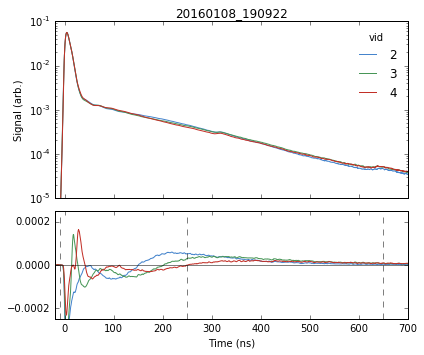

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

# plot setup
fig, ax = plt.subplots(figsize=(6,5))

# background subtraction subplot
divider = make_axes_locatable(ax)
axx = divider.append_axes("bottom", size=1.5, pad=0.18, sharex=ax)

# plot traces
for i, vid in enumerate(pvids):
    bvid = bvids[i]
    x = 1e9 * data[vid]['x']
    norm = np.divide(data[vid]['y'].T, 1e9 * data[vid]['DF'].AC.values).T
    y1 = np.mean(norm, 0)
    bnorm = np.divide(data[bvid]['y'].T, 1e9 * data[bvid]['DF'].AC.values).T
    b1 = np.mean(bnorm, 0)
    reps = len(data[vid]['DF'].index)
    breps = len(data[bvid]['DF'].index)
    sig = sspals.signal(data[vid]['DF'].DF.mean(), data[vid]['DF'].DF.std() / np.sqrt(reps),
              data[bvid]['DF'].DF.mean(), data[bvid]['DF'].DF.std() / np.sqrt(breps))
    ax.plot(x, y1, c=oskar.colors[i%7], label='%d'%vid)
    axx.plot(x, (y1 - b1), c=oskar.colors[i%7])

ax.set_ylim(1e-5, 1e-1)
ax.set_yscale('log')
axx.set_ylim(-0.00025, 0.00025)
#axx.set_yticks([-0.01, 0, 0.01])
plt.locator_params(nbins=4, axis='y')

#format
ax.set_title(rid)
ax.set_xlim(-20, 700)
ax.set_ylabel("Signal (arb.)");
lgd = ax.legend(loc=1, frameon=False, title='vid')
plt.setp(ax.get_xticklabels(), visible=False)
axx.set_xlabel(r"Time (ns)");
plt.axhline(0, color='k', alpha=0.5)
for lim in limits:
    plt.axvline(lim * 1e9, ls='--', c='k', alpha=0.5)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "bsub_sspals.pdf")
plt.savefig(fileout, dpi=600, bbox_inches='tight')
plt.show()

# Optimise

In [7]:
i = 0
all_results = dict()
for vid in pvids:
    bk_vid = bvids[i]
    results = []
    for B in tqdm((np.arange(-5, 650, 10)*1e-9), desc=str(vid), leave=False):
        # background
        bfrac = sspals.sspals(data[bk_vid]['y'], dt, limits=[-10e-9, B, 650e-9]).DF
        bf_mean = bfrac.mean()
        bf_sem= bfrac.std() / np.sqrt(len(bfrac))
        # vid
        dfrac = sspals.sspals(data[vid]['y'], dt, limits=[-10e-9, B, 650e-9]).DF
        df_mean = dfrac.mean()
        df_sem = dfrac.std() / np.sqrt(len(dfrac))
        sig = sspals.signal(df_mean, df_sem, bf_mean, bf_sem)
        results.append([B, sig[0], sig[1]])
    arr = np.array(results)
    all_results[vid] = arr
    i = i + 1

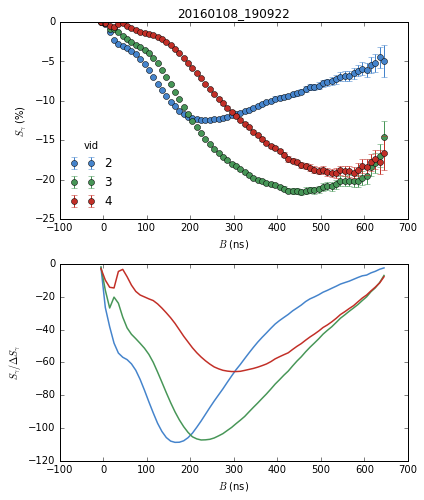

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(6, 7))
for i, vid in enumerate(pvids):
    ax[0].errorbar(all_results[vid][:,0]*1e9, all_results[vid][:,1], 
                   all_results[vid][:,2], fmt='o', c=oskar.colors[i%7], label='%d'%vid)
    ax[1].plot(all_results[vid][:,0]*1e9, all_results[vid][:,1]/ all_results[vid][:,2],
               lw=1.5, c=oskar.colors[i%7])

ax[0].set_title(rid)
lgd = ax[0].legend(loc=0, frameon=False, title='vid')
ax[0].set_xlabel("$B$ (ns)");
ax[0].set_ylabel("$S_\gamma$ (%)");
ax[1].set_xlabel("$B$ (ns)");
ax[1].set_ylabel("$S_\gamma / \Delta S_\gamma$");

ax[0].axhline(0, c='k', alpha=0.5)
ax[1].axhline(0, c='k', alpha=0.5)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "optimise_B.pdf")
plt.savefig(fileout, dpi=600, bbox_inches='tight')
plt.show()